In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import time
import splitfolders
import shutil
import random
import csv
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

main_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir + os.sep + os.pardir)
dataset_dir = os.path.join(main_dir, 'image_dataset')
dataset_dir_2 = os.path.join(main_dir, 'image_dataset_2')
train_dir = os.path.join(dataset_dir_2, 'train')
val_dir = os.path.join(dataset_dir_2, 'val')
test_dir = os.path.join(dataset_dir_2, 'test')

# splits the image dataset into 64% training, 16% validation, and 20% test sets into a new directory
def split_images():
    randNum = random.randint(0, 1337)
    if os.path.exists(dataset_dir_2):
        shutil.rmtree(dataset_dir_2)
    if not os.path.exists(dataset_dir_2):
        os.mkdir(dataset_dir_2)
    splitfolders.ratio(dataset_dir, output=dataset_dir_2, 
                       seed=randNum, ratio=(.64, .16, .2), 
                       group_prefix=None)
    return "Dataset splitting completed"

# saves the training record into csv file for comparison
def save_training_record(model_name, attempt):
    csv_path = os.path.join(main_dir, 'imageClassificationsComparisons.csv')
    csv_file = open(csv_path, 'a', newline='')
    wr = csv.writer(csv_file)
    wr.writerow([model_name, attempt, initial_epochs, earlystopping.stopped_epoch+1-initial_epochs, 
                 training_time, loss1*100, accuracy1*100, (60-compare_predictions_all())])
    csv_file.close()
    return "record saved in csv file successfully"

# compare predictions against label batch in test dataset and count how many wrong predictions
def compare_predictions():
    count_all_wrong = 0
    count_acc_wrong = 0
    count_norm_wrong = 0
    wrong_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] != pred_list[i]:
            count_all_wrong += 1
            wrong_pred_list.append(i)
        if label_list[i] == 0 and pred_list[i] == 1:
            count_acc_wrong += 1
        if label_list[i] == 1 and pred_list[i] == 0:
            count_norm_wrong += 1
    return print("Total Predictions Wrong: %d, Accidents Predictions Wrong: %d, Normal Predictions Wrong: %d" % 
                 (count_all_wrong, count_acc_wrong, count_norm_wrong))


def compare_predictions_all():
    count_all_wrong = 0
    wrong_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] != pred_list[i]:
            count_all_wrong += 1
            wrong_pred_list.append(i)
    return count_all_wrong

def compare_predictions_all_getlist():
    count_all_wrong = 0
    wrong_pred_list = []
    pred_list = predictions.numpy().tolist()
    label_list = label_batch.tolist()
    for i in range(len(label_list)):
        if label_list[i] != pred_list[i]:
            count_all_wrong += 1
            wrong_pred_list.append(i)
    return wrong_pred_list


def print_wrong_image_predictions():
    plt.figure(figsize=(15, 15))
    for i in range(compare_predictions_all()):
      ax = plt.subplot(5, 5, i + 1)
      plt.imshow(image_batch[compare_predictions_all_getlist()[i]].astype("uint8"))
      plt.title(class_names[predictions[compare_predictions_all_getlist()[i]]])
      plt.axis("off")

In [2]:
#Splits the dataset
split_images()

Copying files: 291 files [00:00, 567.25 files/s]


'Dataset splitting completed'

In [3]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                           batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

test_dataset = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                           batch_size=60,
                                                          image_size=IMG_SIZE)

Found 185 files belonging to 2 classes.
Found 46 files belonging to 2 classes.
Found 60 files belonging to 2 classes.


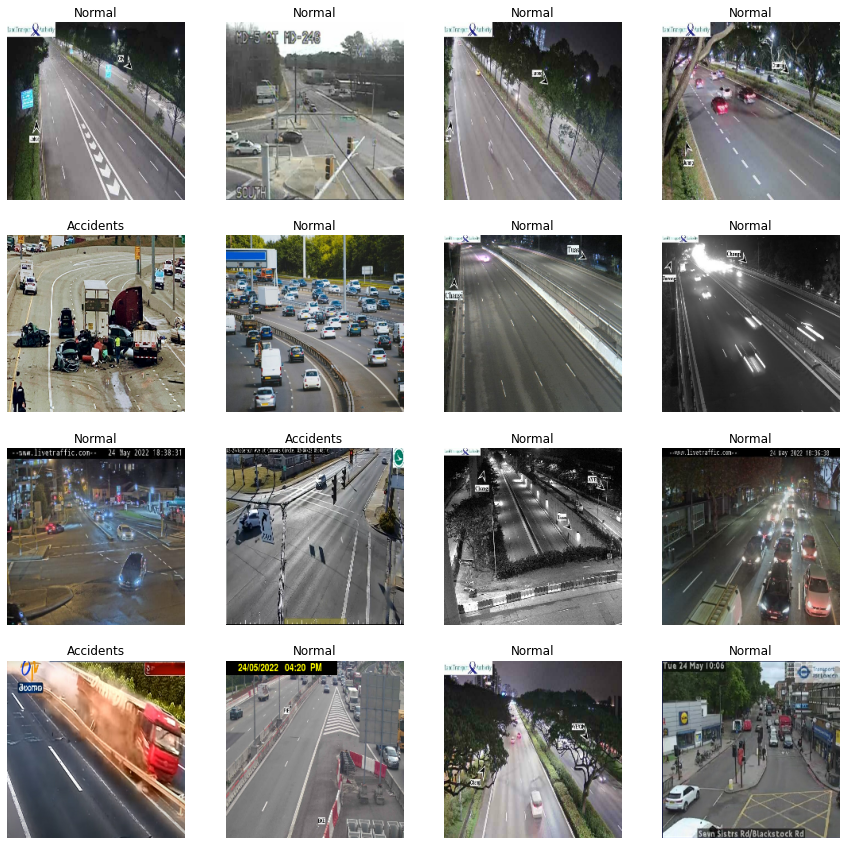

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Configure the Dataset For Performance

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

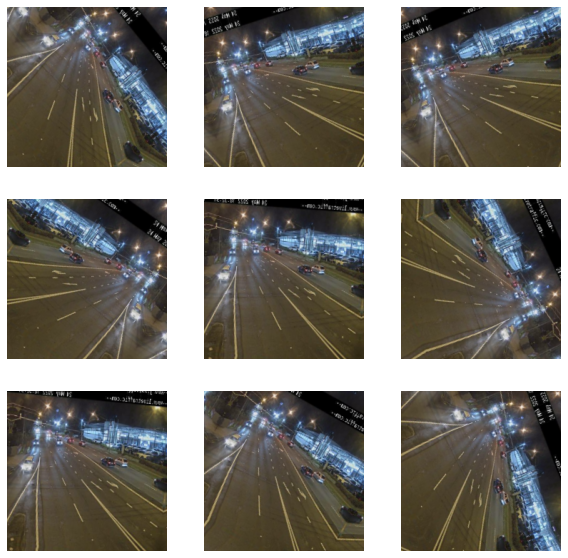

In [6]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

Rescaling Pixel Values

# Creating Base Model from Inception

In [7]:
# Create the base model from the pre-trained model ResNet50
IMG_SHAPE = IMG_SIZE + (3,)
base_model = VGG19(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)


(32, 7, 7, 512)


In [8]:
### Freeze The Convolutional Base
#It is important to freeze the convolutional base before you compile and train the model. 
#Freezing (by setting layer.trainable = False) prevents the weights in a given layer from 
#being updated during training. MobileNet V2 has many layers, so setting the entire model's 
#trainable flag to False will freeze all of them.

base_model.trainable = False

In [9]:
### Important note about BatchNormalization layers

#Many models contain `tf.keras.layers.BatchNormalization` layers. This layer is a special case and precautions 
#should be taken in the context of fine-tuning, as shown later in this tutorial. 

#When you set `layer.trainable = False`, the `BatchNormalization` layer will run in inference mode, and will 
#not update its mean and variance statistics. 

#When you unfreeze a model that contains BatchNormalization layers in order to do fine-tuning, you should keep 
#the BatchNormalization layers in inference mode by passing `training = False` when calling the base model. 
#Otherwise, the updates applied to the non-trainable weights will destroy what the model has learned.

#For more details, see the [Transfer learning guide](https://www.tensorflow.org/guide/keras/transfer_learning).

# Let's take a look at the base model architecture
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
### Add a classification head

#To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [11]:
# Keras Dense layer is added to convert features into a single predictions per image, 
# in which positive numbers predict class 1 (Normal Roads) and negative numbers predict
# no activation is required as predictions will be a logit or raw prediction value

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [12]:
#Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor 
#layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional). As previously mentioned, 
#use `training=False` as our model contains a `BatchNormalization` layer.

inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

# Feature Extraction

In [13]:
### Compile the model

#Compile the model before training it. Since there are two classes, use the `tf.keras.losses.BinaryCrossentropy` 
#loss with `from_logits=True` since the model provides a linear output.

base_learning_rate = 0.00012
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

#The 2.5 million parameters in MobileNet are frozen, but there are 1.2 thousand _trainable_ parameters in the Dense layer. 
#These are divided between two `tf.Variable` objects, the weights and biases.

len(model.trainable_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

2

In [14]:
### Train the model with earlystopping callbacks to avoid overfitting the model. 
# Usually earlystopping will be called in the Fine Tuning phase instead of Feature Extraction

from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

initial_epochs = 50

start_time = time.time()


history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks =[earlystopping])



Epoch 1/50
6/6 [==============================] - 31s 5s/step - loss: 2.8896 - accuracy: 0.3568 - val_loss: 2.8630 - val_accuracy: 0.3913
Epoch 2/50
6/6 [==============================] - 37s 6s/step - loss: 2.6051 - accuracy: 0.3622 - val_loss: 2.5729 - val_accuracy: 0.3478
Epoch 3/50
6/6 [==============================] - 38s 6s/step - loss: 2.1880 - accuracy: 0.4216 - val_loss: 2.3332 - val_accuracy: 0.3696
Epoch 4/50
6/6 [==============================] - 39s 7s/step - loss: 1.9384 - accuracy: 0.4270 - val_loss: 2.1465 - val_accuracy: 0.3696
Epoch 5/50
6/6 [==============================] - 40s 7s/step - loss: 1.9776 - accuracy: 0.4595 - val_loss: 2.0113 - val_accuracy: 0.3696
Epoch 6/50
6/6 [==============================] - 41s 7s/step - loss: 2.3447 - accuracy: 0.3784 - val_loss: 1.8970 - val_accuracy: 0.3478
Epoch 7/50
6/6 [==============================] - 43s 7s/step - loss: 1.8779 - accuracy: 0.4649 - val_loss: 1.8059 - val_accuracy: 0.3913
Epoch 8/50
6/6 [==================

# Fine tuning

In [15]:
#In the feature extraction experiment, you were only training a few layers on top of an MobileNetV2 base model. 
#The weights of the pre-trained network were **not** updated during training.

#One way to increase performance even further is to train (or "fine-tune") the weights of the top layers of the 
#pre-trained model alongside the training of the classifier you added. The training process will force the weights 
#to be tuned from generic feature maps to features associated specifically with the dataset.

#Note: This should only be attempted after you have trained the top-level classifier with the pre-trained model set 
#to non-trainable. If you add a randomly initialized classifier on top of a pre-trained model and attempt to train 
#all layers jointly, the magnitude of the gradient updates will be too large (due to the random weights from the classifier) 
#and your pre-trained model will forget what it has learned.

#Also, you should try to fine-tune a small number of top layers rather than the whole MobileNet model. In most convolutional 
#networks, the higher up a layer is, the more specialized it is. The first few layers learn very simple and generic features 
#that generalize to almost all types of images. As you go higher up, the features are increasingly more specific to the dataset 
#on which the model was trained. The goal of fine-tuning is to adapt these specialized features to work with the new dataset, 
#rather than overwrite the generic learning.

### Un-freeze the top layers of the model


#All you need to do is unfreeze the `base_model` and set the bottom layers to be un-trainable. Then, you should recompile the 
#model (necessary for these changes to take effect), and resume training.

base_model.trainable = True

In [16]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 5

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  19


In [17]:
### Compile the model

#As you are training a much larger model and want to readapt the pretrained weights, it is important to use a lower 
#learning rate at this stage. Otherwise, your model could overfit very quickly.
ft_learning_rate = 0.000008

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=ft_learning_rate),
              metrics=['accuracy'])

model.summary()

len(model.trainable_variables)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                      

22

In [18]:
### Continue training the model

#If you trained to convergence earlier, this step will improve your accuracy by a few percentage points.

fine_tune_epochs = 50
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=(history.epoch[-1]+1),
                         validation_data=validation_dataset,
                         callbacks =[earlystopping])



Epoch 51/100
6/6 [==============================] - 106s 17s/step - loss: 1.1936 - accuracy: 0.6757 - val_loss: 0.5391 - val_accuracy: 0.8043
Epoch 52/100
6/6 [==============================] - 103s 17s/step - loss: 0.5572 - accuracy: 0.7676 - val_loss: 0.3043 - val_accuracy: 0.8913
Epoch 53/100
6/6 [==============================] - 105s 18s/step - loss: 0.4132 - accuracy: 0.8000 - val_loss: 0.2916 - val_accuracy: 0.9130
Epoch 54/100
6/6 [==============================] - 103s 17s/step - loss: 0.3621 - accuracy: 0.8486 - val_loss: 0.2572 - val_accuracy: 0.9565
Epoch 55/100
6/6 [==============================] - 106s 18s/step - loss: 0.3553 - accuracy: 0.8703 - val_loss: 0.2725 - val_accuracy: 0.9130
Epoch 56/100
6/6 [==============================] - 103s 17s/step - loss: 0.3022 - accuracy: 0.8541 - val_loss: 0.2586 - val_accuracy: 0.9565
Epoch 57/100
6/6 [==============================] - 103s 17s/step - loss: 0.3151 - accuracy: 0.8649 - val_loss: 0.2339 - val_accuracy: 0.9565
Epoch 

In [19]:
#Let's take a look at the learning curves of the training and validation accuracy/loss when fine-tuning the last few 
#layers of the MobileNetV2 base model and training the classifier on top of it. The validation loss is much higher than the 
#training loss, so you may get some overfitting.

#You may also get some overfitting as the new training set is relatively small and similar to the original MobileNetV2 datasets.

training_time = time.time() - start_time
print("--- %s seconds taken to train model ---" % (training_time))

acc = history.history['accuracy']
acc += history_fine.history['accuracy']

val_acc = history.history['val_accuracy']
val_acc += history_fine.history['val_accuracy']

loss = history.history['loss']
loss += history_fine.history['loss']

val_loss = history.history['val_loss']
val_loss += history_fine.history['val_loss']

--- 3426.41814994812 seconds taken to train model ---


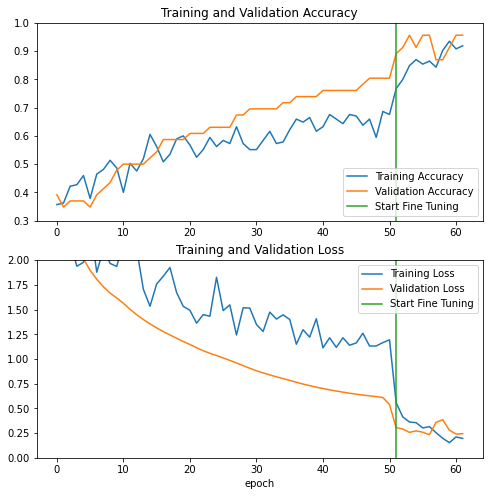

In [20]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.3, 1])
plt.plot([initial_epochs+1,initial_epochs+1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([initial_epochs+1,initial_epochs+1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
### Evaluation and prediction

#Finally you can verify the performance of the model on new data using test set.

loss1, accuracy1 = model.evaluate(test_dataset)
print("The test accuracy is {} and loss is {}".format(accuracy1, loss1))

1/1 [==============================] - 12s 12s/step - loss: 0.2669 - accuracy: 0.9167
The test accuracy is 0.9166666865348816 and loss is 0.2668544054031372


Predictions:
 [1 0 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 0]
Labels:
 [1 0 0 1 1 1 1 0 1 0 0 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1
 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 1 0]


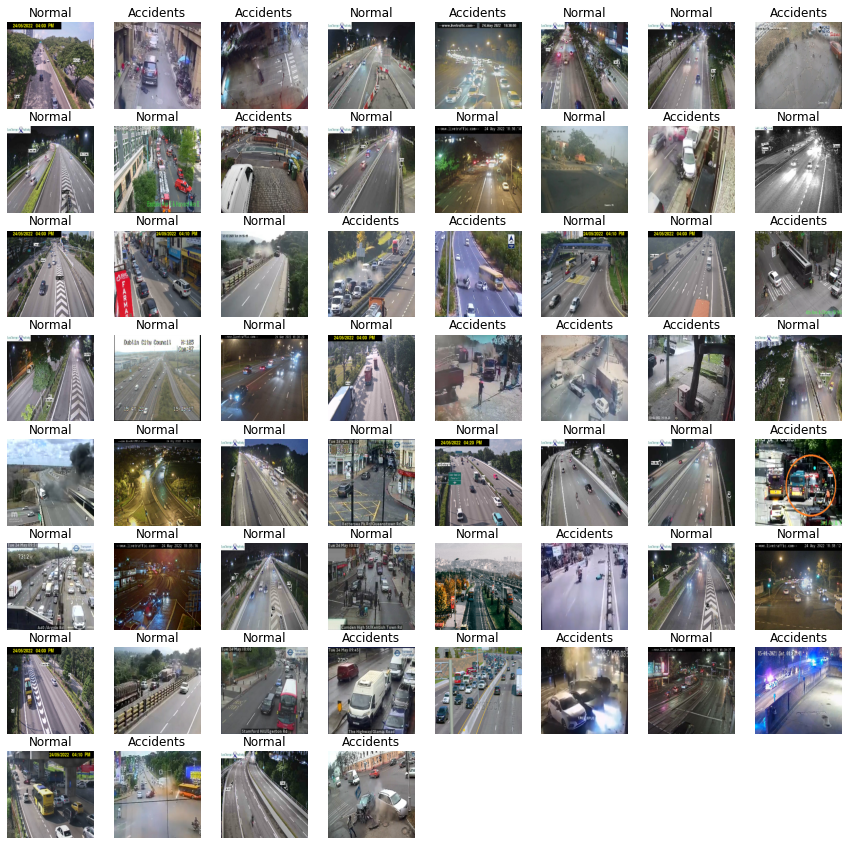

In [22]:
#And now you are all set to use this model to predict if your pet is a normal or accident.

# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(15, 15))
for i in range(60):
  ax = plt.subplot(8, 8, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [23]:
compare_predictions()

Total Predictions Wrong: 7, Accidents Predictions Wrong: 5, Normal Predictions Wrong: 2


In [24]:


print("FE Epoch Undergo: ", initial_epochs)
print("FT Epoch Undergo: ", earlystopping.stopped_epoch+1 - initial_epochs)
print("Loss Percentage: %.2f" % (loss1*100))
print("Accuracy Percentage: %.2f" % (accuracy1*100))
print("Training Time %s seconds: " % (training_time))
print("Correct Predictions out of 60: ", (60-compare_predictions_all()))

save_training_record("VGG19", 1)

FE Epoch Undergo:  50
FT Epoch Undergo:  12
Loss Percentage: 26.69
Accuracy Percentage: 91.67
Training Time 3426.41814994812 seconds
Correct Predictions out of 60:  53


'record saved in csv file successfully'

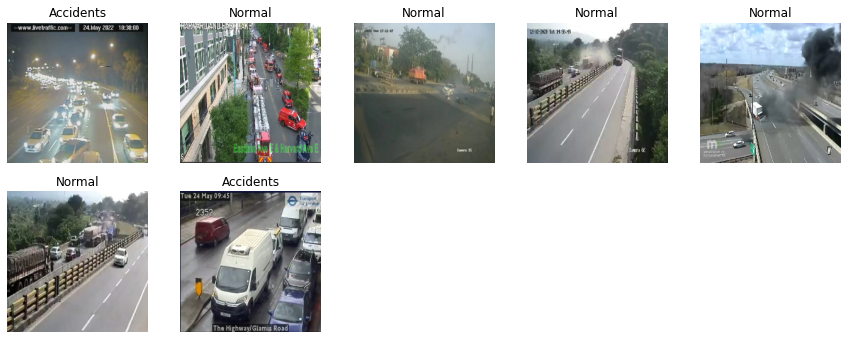

In [25]:
print_wrong_image_predictions()